In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm, binom

# 1. Obtain photos of faces for the experiment.

##### Histogram of  participants

# 2. Conduct Experiment 1

# 3. Pool the rating data

In [2]:
data = pd.read_csv("Data/Rating_Images.csv")
participant1 = data['Rating'][0:460]  # First dataset
participant2 = data['Rating'][461:921]   # Second dataset

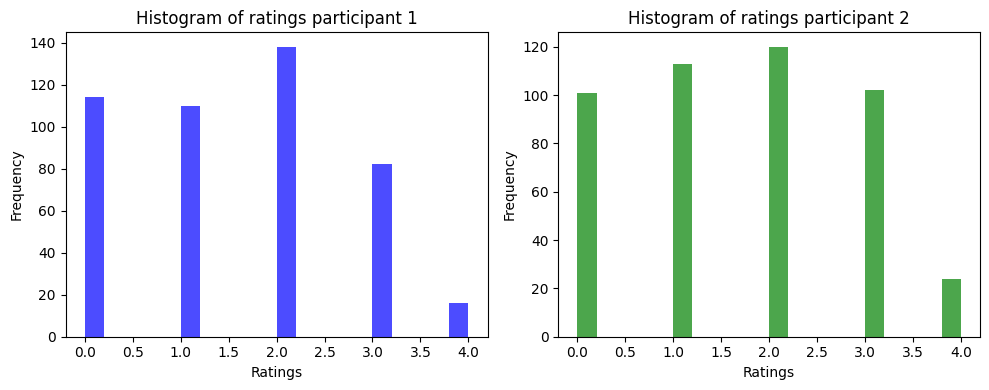

In [3]:
# Create a figure with two subplots
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed

# Plot the first histogram in the left subplot
plt.subplot(1, 2, 1)
plt.hist(participant1, bins=20, color='blue', alpha=0.7)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of ratings participant 1')

# Plot the second histogram in the right subplot
plt.subplot(1, 2, 2)
plt.hist(participant2, bins=20, color='green', alpha=0.7)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of ratings participant 2')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the combined figure with both histograms
plt.show()

¡OJO el min-max normalization! para nosotros no hace falta porque utilizamos ambos participantes la escala completa

# 4. PCA and dimension reductino

#### 1. Cargar todas las imágenes

In [5]:
# Especifica el nombre del archivo CSV que deseas cargar
nombre_archivo = 'Data/vector_images.csv'

# Carga el archivo CSV en un DataFrame de Pandas
dataframe_data = pd.read_csv(nombre_archivo, delimiter=',', header=None)

# Converts DataFrame in a Numpy array
X_data = dataframe_data.to_numpy()

In [6]:
X = X_data
N = len(X)

#### 2. Substract average image from the images

In [7]:
mean_vector = np.mean(X_data, axis=0)
Y = X - mean_vector

#### 3. Run PCA

In [8]:
from scipy.linalg import svd

In [9]:
U,S,Vt = svd(Y,full_matrices=False)

Los scores (la representación de las imágenes en el espacio PCA) son los predictores del linear encoding model. Un score está definido por la multiplicación entre U y S

In [10]:
scores = np.dot(X,Vt.T)

#### 4. Variance explained and selection of PCAs

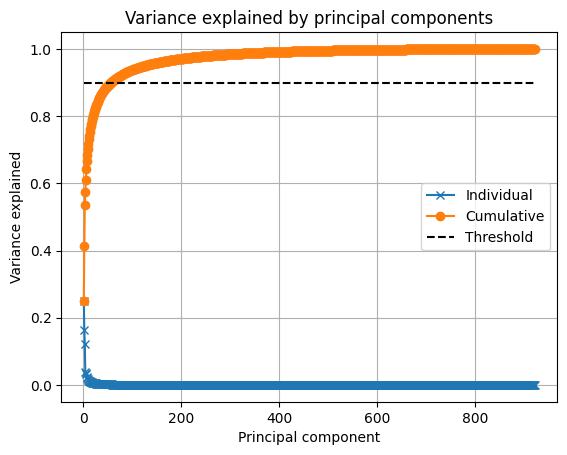

In [11]:
rho = (S*S) / (S*S).sum() 

threshold = 0.9

plt.figure()
plt.plot(range(1,len(rho)+1),rho,'x-')
plt.plot(range(1,len(rho)+1),np.cumsum(rho),'o-')
plt.plot([1,len(rho)],[threshold, threshold],'k--')
plt.title('Variance explained by principal components');
plt.xlabel('Principal component');
plt.ylabel('Variance explained');
plt.legend(['Individual','Cumulative','Threshold'])
plt.grid()
plt.show()

In [12]:
# How many components we want to select over the threshold
positions = np.where(np.cumsum(rho) > threshold)
print('We can consider just', positions[0][0], 'principal components.')

We can consider just 56 principal components.


#### 5. Aux functions for visualization

In [13]:
def reconstruct(vector):
    matrix = vector.reshape((200, 200))
    matrix=np.transpose(matrix)
    return matrix

def show_im(matrix):
    plt.imshow(matrix, cmap='gray')

#### 6. Visualize PCA as images

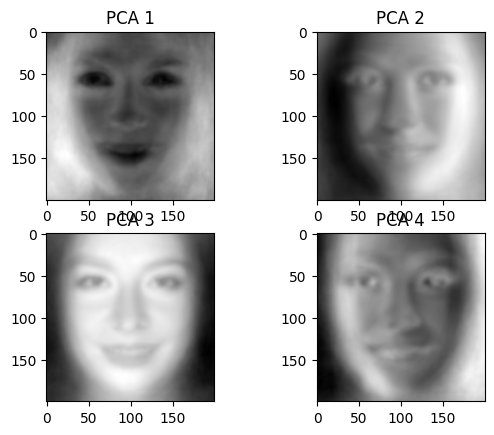

In [14]:
for pc in [1,2,3,4]:
    plt.subplot(2,2,pc)
    show_im(reconstruct(Vt[pc-1,:]))
    plt.title(f"PCA {pc}")

#### 7. Reconstruct images that has max/min score for that component

Recuerda que los Pcs son las **filas** de la matriz Vt (V **traspuesta**) o las **columnas** de la matriz V a secas

The image that has the max score in PC 1 is image number 362 . It has a score of 38875.90464402287
The image that has the min score in PC 1 is image number 850 . It has a score of 6562.740768230375
The image that has the max score in PC 2 is image number 43 . It has a score of 15946.473285027467
The image that has the min score in PC 2 is image number 7 . It has a score of -11900.161117848198
The image that has the max score in PC 3 is image number 379 . It has a score of 20295.13076035656
The image that has the min score in PC 3 is image number 792 . It has a score of -4321.487128721549
The image that has the max score in PC 4 is image number 189 . It has a score of 6323.204420097026
The image that has the min score in PC 4 is image number 848 . It has a score of -9667.0653461277


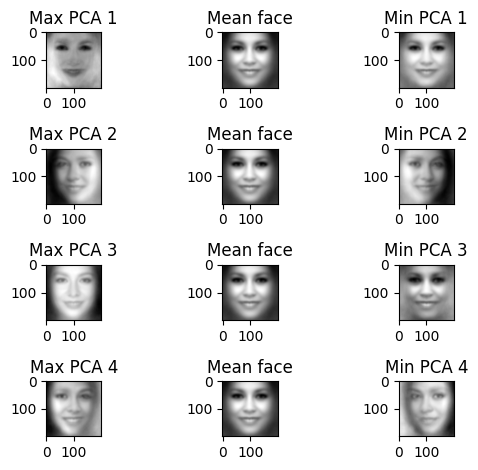

In [15]:
plt.figure()  # Adjust the figure size as needed
for pc in [1,2,3,4]:

    # We select the max and min score by column (by PC)
    im_pc1_max = np.max(scores[:,pc-1])*Vt[pc-1,:] + mean_vector
    im_pc1_min = np.min(scores[:,pc-1])*Vt[pc-1,:] + mean_vector
    print('The image that has the max score in PC', pc, 'is image number', np.argmax(scores[:,pc-1]), '. It has a score of', np.max(scores[:,pc-1]))
    print('The image that has the min score in PC', pc, 'is image number', np.argmin(scores[:,pc-1]), '. It has a score of', np.min(scores[:,pc-1]))
    ## Plotting
    # Create a figure with two subplots


    # Plot the first histogram in the left subplot
    plt.subplot(4, 3, 3*(pc-1) +1)
    show_im(reconstruct(im_pc1_max))
    plt.title(f'Max PCA {pc}')

    # Plot the second histogram in the right subplot
    plt.subplot(4, 3, 3*(pc-1) +2)
    show_im(reconstruct(mean_vector))
    plt.title('Mean face')

    # Plot the second histogram in the right subplot
    plt.subplot(4, 3, 3*(pc-1) +3)
    show_im(reconstruct(im_pc1_min))
    plt.title(f'Min PCA {pc}')

    # Adjust the spacing between subplots
    plt.tight_layout()


# 5. Build a linear regression model

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

Hacemos la proyección de los datos en los PCAS. Para eso, multiplicamos la matriz de imágnees (X) por los 56 primeros PCA por filas, ya que estamos trabajando con Vt. Lo trasponemos después para cuadrar dimensiones

In [19]:
# scores_reduced is the transformed images in 56 components
scores_reduced = np.dot(X, Vt[0:56, :].T)

Hacemos una regresión lineal para intentar ajustar entre los datos transformados. La función sfs.get_support() nos da las features seleccionadas como un array de booleanos. 

In [20]:
y=data['Rating']
regression = LinearRegression()
sfs = SequentialFeatureSelector(regression)
sfs.fit(scores_reduced,y)
sfs.get_support()

array([ True, False, False, False,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True, False, False,  True, False,  True,  True,
       False,  True,  True,  True, False, False, False, False,  True,
        True, False, False, False,  True,  True, False, False,  True,
        True,  True,  True, False, False, False,  True, False, False,
       False,  True])

Una vez hemos seleccionado las features, hemos reducido la dimensionalidad desde 56 a 28 (justo la mitad porque lo teníamos en por defecto). Lo que hacemos ahora es, a partir de B (datos X proyectados únicamente en las 56 primeras PCAs, seleccionar las 28 features que consideramos más interesantes.)

In [21]:
scores_reduced_2=sfs.transform(scores_reduced)
print(scores_reduced_2.shape)

(922, 28)


Ahora, hacemos una regresión lineal para fitear el modelo UNICAMENTE a las features que seleccionamos mediante forward selection. De esta forma, creamos una función del tipo 

$ Rating(y)=a*DatosReducidos(scores_reduced_2) + b$

In [23]:
regression.fit(scores_reduced_2, y)

# Regression coefficients
a_feat = regression.coef_
b_feat = regression.intercept_
print(f"Coef 'a_feat': {a_feat}")
print(f"Coef 'b_feat': {b_feat}")

Coef 'a_feat': [ 2.00534731e-05  3.00645432e-06  4.24807074e-05 -3.78023707e-05
  3.21064015e-05 -6.82703060e-05 -9.38199500e-06 -2.95256243e-05
 -5.95449926e-05  4.43287887e-05 -3.34321994e-05  5.67609336e-05
 -7.19260721e-05  5.15222996e-05  1.33806367e-04 -4.50369215e-05
 -6.39661611e-05  1.41176707e-04 -2.04983608e-05 -9.98137170e-05
 -1.08551925e-04  7.57775862e-05  5.06563844e-05 -5.91520748e-05
  8.05764390e-05  3.31510975e-05  1.18751785e-05 -4.45474641e-05]
Coef 'b_feat': 1.089145079993001


Visualizamos las features selected

In [24]:
# Visualise the PCs that were selected in the same way as you did above
selected_features = np.where( sfs.get_support() == True)
#Sumamos uno para cambiar de índice de Python a orden natural
selected_features = selected_features + np.ones(len(selected_features)) 
no_selected_features = len(selected_features[0])
print('We select', no_selected_features, 'features. The selected pc are the following', selected_features)

We select 28 features. The selected pc are the following [[ 1.  5.  6.  7.  9. 11. 12. 13. 14. 19. 20. 21. 24. 26. 27. 29. 30. 31.
  36. 37. 41. 42. 45. 46. 47. 48. 52. 56.]]


Hacemos lo mismo que hicimos para visualizar los PCA con el máximo y el menor score, pero con las features seleccionadas con el algoritmo de selección de features

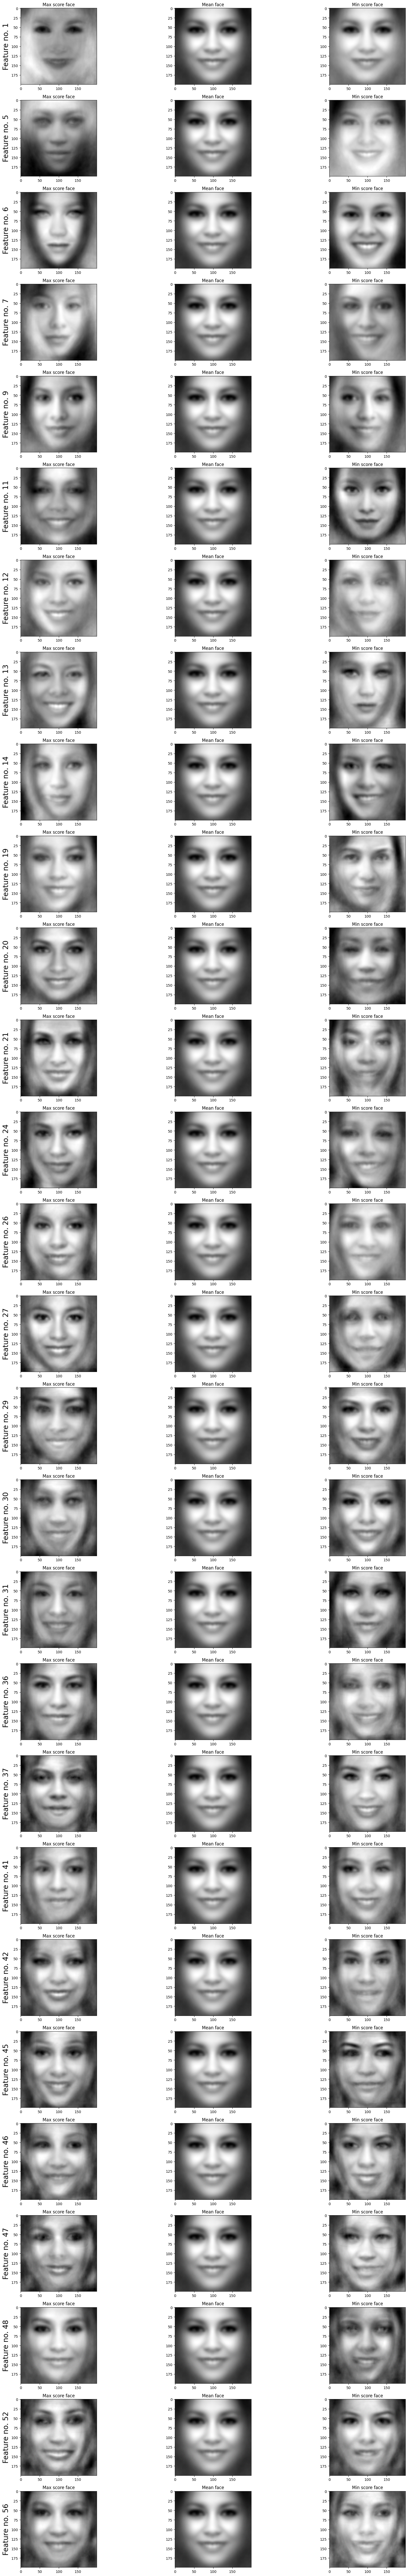

In [25]:
im_pc_max = np.empty((no_selected_features, 40000))
im_pc_min = np.empty((no_selected_features, 40000))

index = 0
# For every selected feature
for f in selected_features[0]:
    pc = int(f)
    # We select the max and min score by column (by PC)
    im_pc_max[index,:] = np.max(scores[:,pc-1])*Vt[pc-1,:] + mean_vector
    im_pc_min[index,:] = np.min(scores[:,pc-1])*Vt[pc-1,:] + mean_vector
    index += 1

# Plotting 
# Create a figure with subplots
plt.figure(figsize=(20, 100))  # Adjust the figure size as needed

plot_index = 1
for i in range(0, no_selected_features):
    
    # Plot the first image in the left subplot
    plt.subplot(no_selected_features, 3, plot_index)
    show_im(reconstruct(im_pc_max[i,:]))
    plt.title('Max score face')
    plt.ylabel('Feature no. '+ str(int(selected_features[0][i])), size=20)
    
    # Plot the second image in the middle subplot
    plt.subplot(no_selected_features, 3, plot_index+1)
    show_im(reconstruct(mean_vector))
    plt.title('Mean face')

    # Plot the third image in the right subplot
    plt.subplot(no_selected_features, 3, plot_index+2)
    show_im(reconstruct(im_pc_min[i,:]))
    plt.title('Min score face')
    
    plot_index += 3
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()

# 6. Generate synthetic images from the model

Para poder generar imágenes sintéticas a partir de un rating dado, debemos despejar de nuestro modelo lineal generado. 
Sabiendo que nuestro modelo se define como 

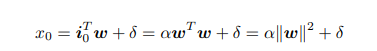

Por ello, para poder generar una imagen, simplemente tenemos que despejar a partir de esa ecuaciónn

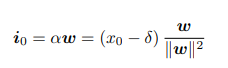

Primero de todo, debemos obtener la norma del vector w, que no deja de ser el vector a obtenido en el modelo de regresión lineal. 

In [26]:
ind=selected_features -np.ones(len(selected_features))
ind=ind.astype(int)
selected_PCs=Vt[ind]
norm_w_sqr=np.linalg.norm(a_feat)**2

Ahora, siguiendo las fórmulas, podemos reconstruir.

(1, 40000)


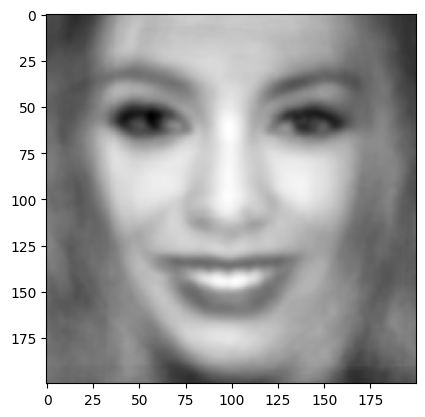

In [27]:
rating_user=2
alfa=(float(rating_user) - b_feat)/norm_w_sqr
i0=alfa*a_feat
reconst_img=np.dot(i0,selected_PCs) + mean_vector
print(reconst_img.shape)
show_im(reconstruct(reconst_img))

Para poder generar imágenes sintéticas a partir de todos los ratings de la escala:

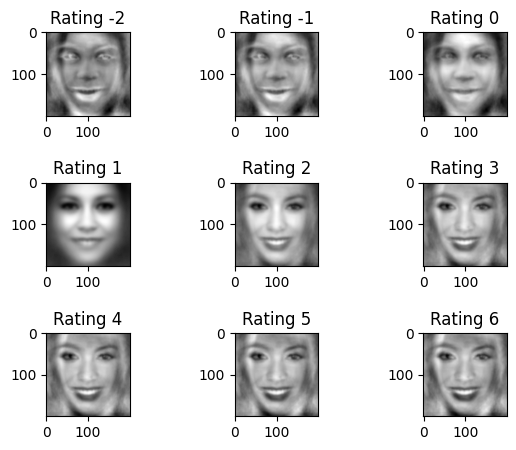

In [28]:
rating_vec=range(-2,7)
for rat in rating_vec: 
    plt.subplot(3,3,rat+3)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.8)
    alfa=(float(rat) - b_feat)/norm_w_sqr
    i0=alfa*a_feat
    reconst_img=np.dot(i0,selected_PCs) + mean_vector
    show_im(reconstruct(reconst_img))
    plt.title("Rating " + str(rat))

# 7. Conduct Experiment 2 Over Synthetic Img

In [29]:
exp2 = pd.read_csv("Data/Rating_Synthetic_Images.csv")

# The column 'Result' is the comparison between getting a rating equal to the true rating
y_result = exp2['Result']
y_rating = exp2['Rating']
y_real_rating=exp2['Real_rating']

Text(0, 0.5, 'Frequency')

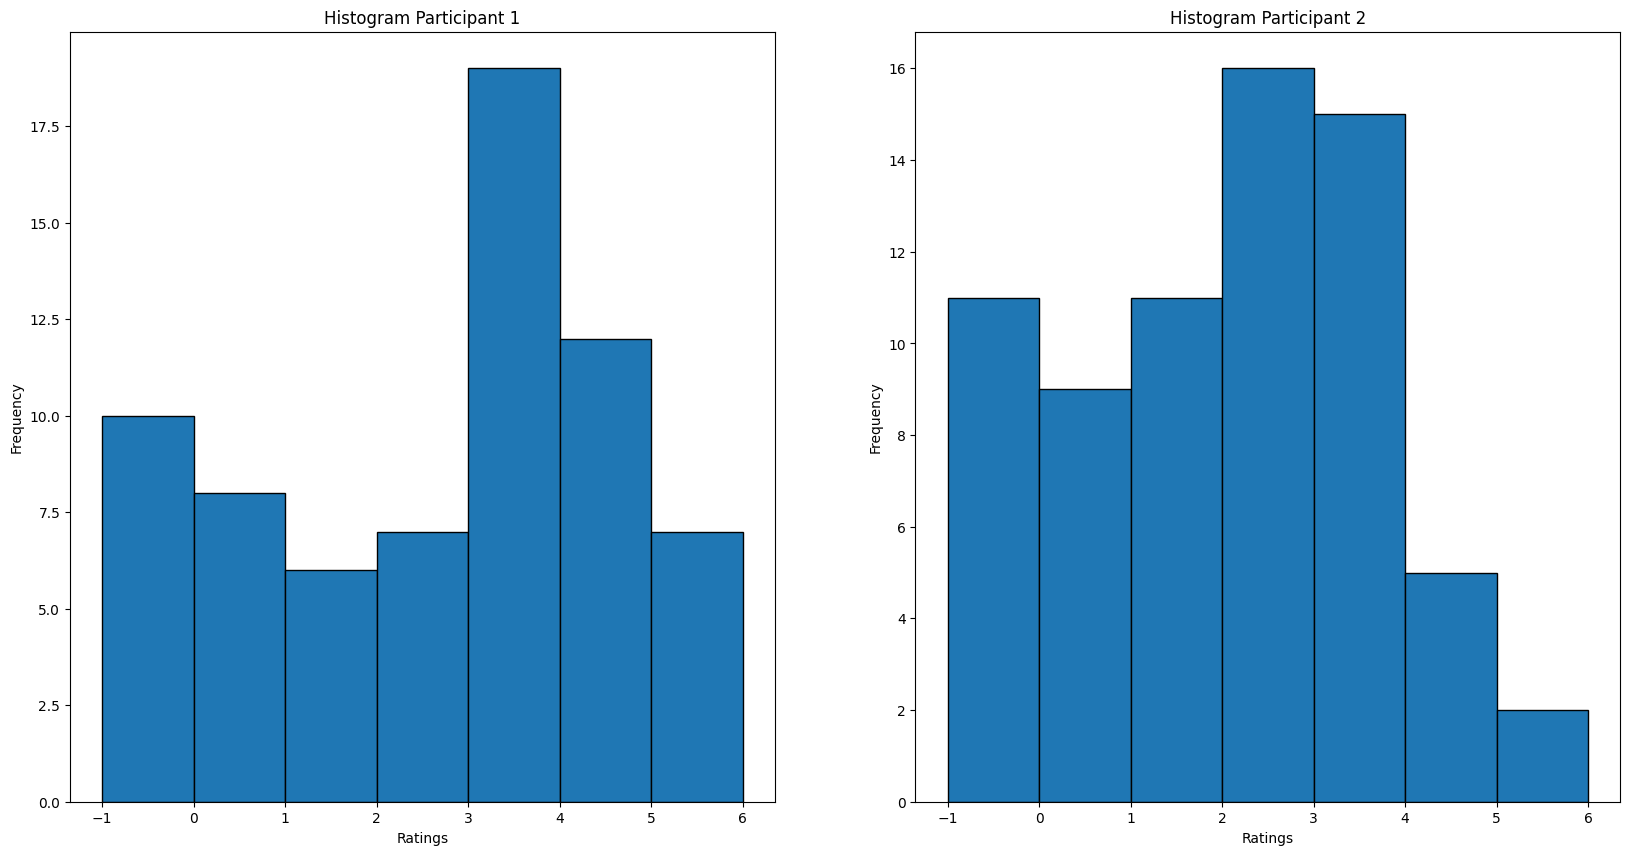

In [30]:
y_ratings_list = [y_rating[0:69], y_rating[70:139]]
results = []
for i, y_ratings in enumerate(y_ratings_list, start=1):
    response_counts = {-1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4:0, 5:0}
    
    for rating in y_ratings:
        response_counts[rating] += 1
    
    total_responses = len(y_ratings)
    response_proportions = {key: count / total_responses for key, count in response_counts.items()}
    
    results.append({
        'Participant': f'Participant {i}',
        'Response Counts': response_counts,
        'Response Proportions': response_proportions
    })

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
participant_1_ratings = y_ratings_list[0]
plt.hist(participant_1_ratings, bins=7, range=(-1, 6), edgecolor='black')
plt.title('Histogram Participant 1')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
# Crear un histograma para el segundo participante (índice 1 en y_ratings_list)
participant_2_ratings = y_ratings_list[1]
plt.hist(participant_2_ratings, bins=7, range=(-1, 6), edgecolor='black')
plt.title('Histogram Participant 2')
plt.xlabel('Ratings')
plt.ylabel('Frequency')


# 8. Analyze the data

Since we have 7 response categories (from -1 to 5), we have 6 response criterions: c1 = -0.5, c2 = 0.5, c3 = 1.5, c4 = 2.5, c5 = 3.5, c6 = 4.5

In [31]:
crit = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])

unique, counts = np.unique(np.array(exp2['Rating']), return_counts=True)
unique_result, counts_result = np.unique(np.array(exp2['Real_rating']), return_counts=True)

# Same for participant 1
unique_participant1, counts_participant1 = np.unique(np.array(exp2['Rating'][0:70]), return_counts=True)
unique_result_participant1, counts_result_participant1 = np.unique(np.array(exp2['Real_rating'][0:70]), return_counts=True)

# Same for participant 2
unique_participant2, counts_participant2 = np.unique(np.array(exp2['Rating'][70:140]), return_counts=True)
unique_result_participant2, counts_result_participant2 = np.unique(np.array(exp2['Real_rating'][70:140]), return_counts=True)


Creamos una función para la ROC curve siguiendo lo que hicimos en el HW1. Básicamente, dependiendo del criterio, todas las respuestas que estén por encima del criterio se considera positivo y todo lo que esté por debajo es negativo. Básicamente, automatizamos ese proceso para ver si el criterio.

In [32]:
def ROC_curve_data(rating, real_rating):
    crit = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
    TPR, FPR=[], []
    for c in crit:
        Ns=0
        Ns0=0
        TP=0
        FP=0
        for i in range(len(rating)):
            rat=rating[i]
            real_rat=real_rating[i]
            if real_rat>c:
                Ns+=1
                if rat>c:
                    TP+=1
            else:
                Ns0+=1
                if rat>c:
                    FP+=1
            #input(f"c={c} TP={TP} Ns={Ns} FP={FP} Ns0={Ns0}")
        TPR.append(TP/Ns)
        FPR.append(FP/Ns0)
        #input(f"c={c} TP={TP} Ns={Ns} FP={FP} Ns0={Ns0} TPR={TP/Ns:.2f} FPR={FP/Ns0:.2f}")

    TPR.append(0)
    FPR.append(0)
    TPR.append(1)
    FPR.append(1)
    FPR.sort()
    TPR.sort()
    return TPR, FPR

Ploteamos el ROC curve para cada participante. Definimos el baseline stimulus como el array b. Para sacar el AUC lo sacamos de sklearn

In [33]:

valores_unicos, frecuencias = np.unique(list(exp2['Rating'][0:70]), return_counts=True)

# Crear un diccionario con los resultados
resultado = dict(zip(valores_unicos, frecuencias))

print("Frecuencia de cada valor:")
print(resultado)

Frecuencia de cada valor:
{-1: 10, 0: 8, 1: 7, 2: 7, 3: 19, 4: 12, 5: 7}


[0, 0.2727272727272727, 0.5238095238095238, 0.8787878787878788, 1.0, 1.0, 1.0, 1]
[0.0, 0.0, 0, 0.06779661016949153, 0.09090909090909091, 0.16326530612244897, 0.24324324324324326, 1]


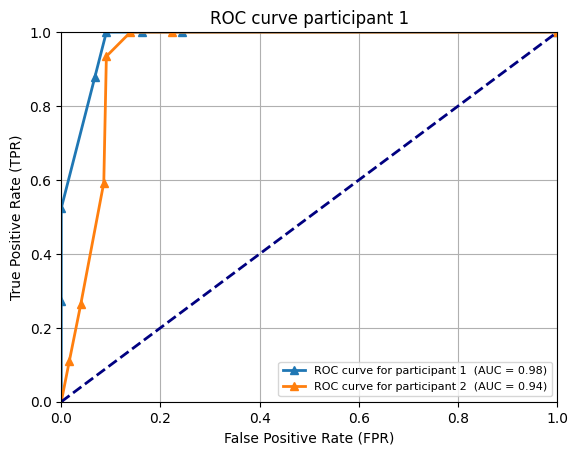

In [34]:
from sklearn.metrics import auc
plt.figure()
TPR, FPR = ROC_curve_data(list(exp2['Rating'][0:70]), list(exp2['Real_rating'][0:70]))
print(TPR)
print(FPR)
roc_auc = auc(FPR, TPR)
plt.plot(FPR, TPR,'-', lw=2, marker="^", label='ROC curve for participant 1 '+' (AUC = %0.2f)' % roc_auc)
TPR, FPR = ROC_curve_data(list(exp2['Rating'][70:140]), list(exp2['Real_rating'][70:140]))
roc_auc = auc(FPR, TPR)
plt.plot(FPR, TPR,'-', lw=2, marker="^", label='ROC curve for participant 2 '+' (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve participant 1')
plt.legend(loc='lower right', fontsize=8)
plt.grid()

Ahora, debemos fittear funciones psicométricas como hemos hecho mil veces

In [35]:
def model1(I, c, sigma):
    return norm.cdf((I-c)/sigma)

In [36]:
from scipy.stats import binom
def negative_log_likelihood(params, I, N_correct, N_s, function=1, P_guess = None):
    c, sigma = params[0],params[1]
    if function ==1 :
        probabilities = model1(I, c, sigma)
    else:
        raise ValueError("Invalid function name. Supported functions: 'psycometric_1', 'psycometric_2', 'psycometric_3'")

    log_likelihood = sum([binom.logpmf(N, N_s, p) for N, p in zip(N_correct, probabilities)])   # We can see the likelihood of a point as how possible is to have a value given a function with theirs parameters. In this case, the likelihood of each point can be calculated using a binomial distribution. Then to see the likelihood of all the 6 points of the intensity of the stimulus, we should multiply their likelihood because we consider them i.i.d points, however we are using the log-likelihood so we can sum their logarithms.
    return -log_likelihood